<a href="https://colab.research.google.com/github/Ketaki-conda/Blog/blob/master/Handwritten_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/Dataset/words.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/words/p06/p06-088/p06-088-02-03.png  
 extracting: /content/data/words/p06/p06-088/p06-088-02-04.png  
 extracting: /content/data/words/p06/p06-088/p06-088-02-05.png  
 extracting: /content/data/words/p06/p06-088/p06-088-02-06.png  
 extracting: /content/data/words/p06/p06-088/p06-088-02-07.png  
 extracting: /content/data/words/p06/p06-088/p06-088-02-08.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-00.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-01.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-02.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-03.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-04.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-05.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-06.png  
 extracting: /content/data/words/p06/p06-088/p06-088-03-07.png  
 extracting: /content/data/words/p06/p0

In [ ]:
data_location = '/content/data/words'

In [ ]:
def get_paths_and_gts(partition_split_file):
    paths_and_gts = []
    
    with open(partition_split_file) as f:
        for line in f:
            if not line or line.startswith('#'):
                continue
            
            line_split = line.strip().split(' ')
            
            directory_split = line_split[0].split('-')
            
            image_location = f'{data_location}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{line_split[0]}.png'
            
            gt_text = ' '.join(line_split[8:])
            
            
            paths_and_gts.append([image_location, gt_text])
    
    return paths_and_gts

In [ ]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

In [ ]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


In [ ]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [ ]:
train_files = get_paths_and_gts('drive/MyDrive/Dataset/train_files.txt')
valid_files = get_paths_and_gts('drive/MyDrive/Dataset/valid_files.txt')
test_files = get_paths_and_gts('drive/MyDrive/Dataset/test_files.txt')
len(train_files), len(valid_files), len(test_files)

(87292, 4316, 4316)

In [ ]:
for index, (img_loc, gt_text) in enumerate(train_files):
    if 'r06-022-03-05' in img_loc:
        print(index)
    else:
        continue

4576


In [ ]:
train_files[4576]

['/content/data/words/r06/r06-022/r06-022-03-05.png', 'more']

In [ ]:
del train_files[4576]
print(train_files[4576])

['/content/data/words/g06/g06-042e/g06-042e-05-03.png', 'notice']


CITIZENS


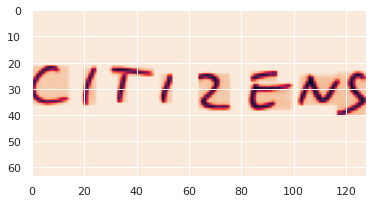

In [ ]:
i = 21
print(train_files[i][1])
an_img = preprocess(path=train_files[i][0], img_w=128, img_h=64)
plt.imshow(an_img)

In [ ]:
class TextImageGenerator:
    
    def __init__(self, data,
                 img_w,
                 img_h, 
                 batch_size, 
                 i_len,
                 max_text_len):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = preprocess(img_filepath, self.img_w, self.img_h)
            self.imgs[i, :, :] = img
            self.texts.append(text)
     
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [ ]:
batch_size = 64
input_length = 30
max_text_len = 16
img_w = 128
img_h = 64

In [ ]:
train_data = TextImageGenerator(train_files, img_w, img_h, batch_size, input_length, max_text_len)
train_data.build_data()

In [ ]:
train_data.imgs.shape

(87291, 64, 128)

In [ ]:
validation_data = TextImageGenerator(valid_files, img_w, img_h, batch_size, input_length, max_text_len)
validation_data.build_data()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

# CNN to RNN
iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

# RNN layer
# layer ten
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
# layer nine
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)

# transforms RNN output to character activations:
iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['the_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                              

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics = ['accuracy', 'mse'])

In [ ]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_save_cb = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/OCR on IAM Models/two-weights-epoch{epoch:02d}-val_loss{val_loss:.3f}.h5',
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [ ]:
batch_size, train_data.n, validation_data.n

(64, 87291, 4316)

In [ ]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=validation_data.next_batch(),
                            steps_per_epoch=train_data.n/batch_size,
                            validation_steps=validation_data.n // batch_size,
                            epochs=50,
                            callbacks= [epoch_times,reduce_learning_rate_cb,model_save_cb])

Epoch 1/50
1364/1363 [==============================] - ETA: 0s - loss: 8.9602 - accuracy: 0.1445 - mse: 205.0975 ;validation took 0.1026 minutes.
 ;epoch 1 took 2.9267 minutes.

Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/OCR on IAM Models/two-weights-epoch01-val_loss4.192.h5
1363/1363 [==============================] - 178s 116ms/step - loss: 8.9602 - accuracy: 0.1445 - mse: 205.0975 - val_loss: 4.1922 - val_accuracy: 0.2183 - val_mse: 42.7396 - lr: 0.0010
Epoch 2/50
1364/1363 [==============================] - ETA: 0s - loss: 2.5356 - accuracy: 0.4399 - mse: 23.1104 ;validation took 0.0623 minutes.
 ;epoch 2 took 2.5132 minutes.

Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/OCR on IAM Models/two-weights-epoch02-val_loss2.135.h5
1363/1363 [==============================] - 151s 111ms/step - loss: 2.5356 - accuracy: 0.4399 - mse: 23.1104 - val_loss: 2.1349 - val_accuracy: 0.4949 - val_mse: 17.7637 - lr: 0.0010
Epoch 3/50
1364/1363 [============

In [ ]:
model.save(filepath='/content/drive/My Drive/HandwrittenWordsModel-Try4.h5', overwrite=False, include_optimizer=True)

[WARNING] /content/drive/My Drive/HandwrittenWordsModel-Try4.h5 already exists - overwrite? [y/n]n


In [ ]:
import seaborn as sns

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

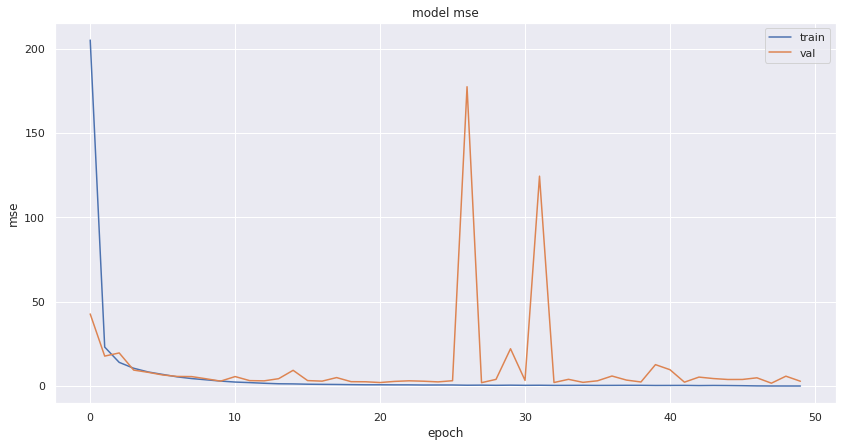

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['mse'])
plt.plot(history_model_3.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

examine


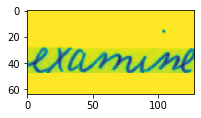

In [ ]:
import seaborn as sns
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 23
print(test_files[i][1])
temp_processed_image = preprocess(path=test_files[i][0], img_w=128, img_h=64)
plt.imshow(temp_processed_image)

In [ ]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

In [ ]:
print(original_test_texts)

['certain', 'biographies', 'all', 'It', 'I', 'show', 'Kings', 'A', 'the', 'and', '.', 'to', 'have', 'new', 'were', 'meant', 'that', 'by', "didn't", 'gesture', 'town', '.', 'him', 'examine', 'Burge', 'about', 'off', 'would', 'with', 'the', 'My', 'After', 'energetic', '.', "'", 'see', 'so', 'the', 'frostbite', 'nature', 'It', '.', 'Long', 'are', ',', 'is', '357million', 'are', 'to', 'eye', 'no', 'be', 'the', 'which', 'had', 'pathogens', 'will', 'at', 'or', 'believed', 'Sir', 'the', 'flawed', 'tradition', ',', 'cave', 'Jury', 'the', 'diplomatist', 'express', 'generate', 'Edinburgh', 'a', 'it', 'primitive', 'the', 'the', 'across', 'have', 'adequate', 'insisted', 'been', ':', 'in', 'the', 'purchases', 'warming', 'negotiations', 'Sir', '.', 'a', 'implication', '1', 'television', 'attempt', 'will', 'smoke', 'reason', '.', 'actions', 'last', '.', '1', 'attention', 'his', 'MONEY', 'he', 'be', 'VIENNA', 'Preference', 'is', 'appointment', 'misguided', 'three', 'life', 'utmost', 'went', 'straight'

In [ ]:
print(len(test_files))
print(len(test_images_processed))
print(len(original_test_texts))

4316
4316
4316


In [ ]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

(4316, 128, 64)

In [ ]:
iam_model_pred = None
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 128, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 64, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 128, 64, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 64, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 32, 128)       73856     
                                                           

In [ ]:
iam_model_pred.load_weights(filepath='/content/drive/My Drive/HandwrittenWordsModel-Try4.h5')

In [ ]:
print(iam_model_pred)

In [ ]:
test_predictions_encoded = iam_model_pred.predict(x=test_images_processed)
test_predictions_encoded.shape

(4316, 32, 80)

In [ ]:
test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(test_predictions_encoded,
                                                                                  input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
                                                                                  greedy=True)[0][0])
test_predictions_decoded.shape

(4316, 32)

In [ ]:
def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[i] for i in numbered_array)

In [ ]:
print("predicted text = ", numbered_array_to_text(test_predictions_decoded[0]))

predicted text =  7certain


In [ ]:
preds = []
for i in test_predictions_decoded:
  preds.append(numbered_array_to_text(i))
preds

['7certain',
 '7biographies',
 '7all',
 'It',
 'I',
 'Sshow',
 '7Kings',
 '7A',
 '7the',
 "7'and",
 '-.',
 '7to',
 '4have',
 '7new',
 '!were',
 'meant',
 '!that',
 '!by',
 "!didn't",
 '7gesture',
 '7town',
 '-.',
 '?him',
 "7'examine",
 'Burge',
 '7about',
 '!of',
 '!would',
 '!with',
 '!the',
 'My',
 '7After',
 '7energetic',
 '-.',
 "!,'",
 '!zsee',
 '#so',
 '!the',
 '7frostbite',
 '-nature',
 '7It',
 '-.',
 '6Long',
 'xare',
 '-,',
 '-is',
 '7357million',
 '7are',
 '6to',
 "7'eye",
 '-no',
 '-Hbe',
 '-the',
 'which',
 '7had',
 'pathogens',
 '!will',
 '7Iat',
 ' Dor',
 'believed',
 'Sir',
 '-the',
 '7flawed',
 '7tradition',
 '-,',
 ':cave',
 '7Jury',
 '-the',
 '!diplomatist',
 'Eexpress',
 '7generate',
 'Edinburgh',
 'qa',
 'Iit',
 '7primitive',
 '-the',
 '!the',
 '7across',
 '?have',
 '7adequate',
 '7insisted',
 'been',
 '!:',
 '-in',
 '-the',
 'purchases',
 '!warming',
 'qnegotiations',
 'Sir',
 '-.',
 '7a',
 '!implication',
 '?I1',
 '7Itelevision',
 '7attempt',
 '!will',
 '-Ismoke'

## ACCURACY 1 - (Correct pred/ total) * 100
### Correct = if(ans is substring of prediction)

In [ ]:
count = 0
for _itr in range(len(preds)):
  if(preds[_itr].find(original_test_texts[_itr]) != -1):
    count += 1
print("Accuracy : ", count / len(preds) * 100, " %")

Accuracy :  98.4244670991659  %


## ACCURACY 2

In [ ]:
def LCSubStr(X, Y, m, n):
    LCSuff = [[0 for k in range(n+1)] for l in range(m+1)]
    result = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if (i == 0 or j == 0):
                LCSuff[i][j] = 0
            elif (X[i-1] == Y[j-1]):
                LCSuff[i][j] = LCSuff[i-1][j-1] + 1
                result = max(result, LCSuff[i][j])
            else:
                LCSuff[i][j] = 0
    return result

In [ ]:
acc = 0
for x in range(len(preds)):
  c = LCSubStr(preds[x], original_test_texts[x], len(preds[x]), len(original_test_texts[x]))
  acc += c/len(original_test_texts[x])
print("ACCURACY = " , acc/len(preds) * 100)

ACCURACY =  99.15077476071453
